In [ ]:
# Imports

#Dwave imports
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
import dimod
from __future__ import print_function

import dimod
import math
import sys
import copy

from dimod.generators.constraints import combinations
from hybrid.reference import KerberosSampler

#Impots for QUBO problem
import numpy as np
from numpy import linalg as LA
import pandas as pd
import matplotlib as plt
import itertools as it
from itertools import product
from matplotlib import pyplot as plt
import math

import matplotlib.pyplot as plt
import networkx as nx

All additional information is in the notes written with the Micheletti paper that this code aims to recreate 

In [4]:
# Header template:


'''
LOGIC:

INPUTS:

OUTPUTS:

'''

'\nLOGIC:\n\nINPUTS:\n\nOUTPUTS:\n\n'

In [70]:
# Code to find the set of indicies that are next to vertex p. Verticies are labeled numerically from 0 to N^2 - 1
# We note that the index can be encoded as a tuple via p = px*n+py, hence py = p mod n and px = (i - iy)/n

def next_to(p,n,T):
    '''
    LOGIC:
        Starting from the integer position value of a vertix, find the (x,y) coords using (x,y) = ((p-py)//n, p % n)

    INPUTS:
        p   : Tuple of integer position value and colour key
        n   : Grid size (nxn)
        T   : Boundary conitions

    OUTPUTS:
        neighbours  : List containing the neighbours of each input p on a grid of size (nxn) with boundary conditions T
    '''
    p = p[0]
    if T == 'Default':
        py = p % n # the y coordinate (y in {0,...,n-1})
        px = (p - py)//n # the x coordinate (x in {0,...,n-1})
        # print((px,py))
        adjacent_set = []
        if px + 1 < n and px + 1 >= 0:
            adjacent_set.append((px + 1, py))
        if px - 1 < n and px - 1 >= 0:
            adjacent_set.append((px - 1, py))
        if py + 1 < n and py + 1 >= 0:
            adjacent_set.append((px, py + 1))
        if py - 1 < n and py - 1 >= 0:
            adjacent_set.append((px, py - 1)) 
        tensors = []
        neighbours = []
        
    
    elif T == 'Periodic':
        py = int(p % n) # the y coordinate (y in {0,...,n-1})
        px = int((p - py)/n) # the x coordinate (x in {0,...,n-1})
        # print((px,py))
        adjacent_set = []
        adjacent_set.append(((px + 1) % n, py))
        adjacent_set.append(((px - 1) % n, py)) 
        adjacent_set.append((px, (py + 1) % n))
        adjacent_set.append((px, (py - 1) % n)) 
        tensors = []
        neighbours = []
        # print(f'G_{p}')



    elif T == 'X Shift':
        shift = 1
        py = int(p % n) # the y coordinate (y in {0,...,n-1})
        px = int((p - py)/n) # the x coordinate (x in {0,...,n-1})
        # print((px,py))
        adjacent_set = []
        

        #Bulk
        if px not in [0,n-1]:
            adjacent_set.append(((px + 1) % n, py))
            adjacent_set.append(((px - 1) % n, py)) 
            adjacent_set.append((px, (py + 1) % n))
            adjacent_set.append((px, (py - 1) % n)) 
            # print('Bulk point: ',adjacent_set)
        #x lower boundary
        elif px == 0:
            adjacent_set.append(((px + 1) % n, py))
            adjacent_set.append(((px - 1) % n, (py - shift) % n)) 
            adjacent_set.append((px, (py + 1) % n))
            adjacent_set.append((px, (py - 1) % n))
            # print('lower x point: ', adjacent_set)
        #x upper boundary
        elif px == n-1:
            adjacent_set.append(((px + 1) % n, (py + shift) % n))
            adjacent_set.append(((px - 1) % n, py % n)) 
            adjacent_set.append((px, (py + 1) % n))
            adjacent_set.append((px, (py - 1) % n))
            # print('upper x point: ', adjacent_set)
    
    neighbours = []
    for x,y in adjacent_set:
        neighbours.append(x*n + y)
    return neighbours

        


# Get all bonds globally
def get_all_bonds_global(n,colours):
    '''
    LOGIC:
        Find all the edges on the graph by iterating over everypoint and finding their neightbours using the "edge_set(p,n)" function.

    INPUTS:
        n   : Grid size (nxn)

    OUTPUTS:
        bonds   : List of all edges
    '''
    bonds = []
    for C in colours:
        for j in range(n**2):
            for c in colours:
                for p in next_to((j,C),n, T = BC):
                    bonds.append(bond_map(f'G_{j}_{p}_{C}_{c}'))
                    bonds = list(set(bonds))
    return bonds

# Get all local bonds
def get_all_bonds(j,n,colours):
    '''
    LOGIC:
        Find the set of edges connected to vertex p on a grid of size (nxn) using the "nexy_to(p,n,T)" function ordered from low to high.

    INPUTS:
        j   : (integer,string)
        n   : Grid size (nxn)

    OUTPUTS:
        edge_set    : List of rank 2 tensors representing the edges
    '''
    bonds = []
    for cp in colours:
        for p in next_to(j,n, T = BC):
            bonds.append(bond_map(f'G_{j[0]}_{p}_{j[1]}_{cp}'))
    bonds = list(set(bonds))
    return bonds

# Bond map G_j_i -> G_i_j where i < j
def bond_map(bond):
    '''
    LOGIC:
        Ensure the uniqueness of every rank 2 tensor by ordering the indicies from high to low. The inout string is split and the numerical values are sorted from high to low.

    INPUTS:
        bond    : String of the form "G_i_j"

    OUTPUTS:
        bonds   : String of the form "G_i_j" where i < j
    '''
    # print(bond)
    G,i,j,ci,cj = bond.split('_')
    if int(i) < int(j):
        return f'G_{int(i)}_{int(j)}_{ci}_{cj}'
    else:
        return f'G_{int(j)}_{int(i)}_{cj}_{ci}'

# Decompose bonds
def decompose_bond(bond):
    '''
    LOGIC:
        Find the verticies that cap each end of a bond by splitting the input string and keeping the indicies.

    INPUTS:
        bond    : String of the form "G_i_j"

    OUTPUTS:
        decomp  : Strings of the form "G_i","G_j" where i and j are the vertices at each end of the input bond.
    '''
    
    A = bond.split('_')
    G = A[0]
    i = A[1]
    j = A[2]
    ci = A[3]
    cj = A[4]
    decomp = [f'G_{i}_{ci}',f'{G}_{j}_{cj}']
    return decomp

# Corner map G_i_j_k -> G_k_j_i wherer k < i
def _3_tensors_map(tensor_3):
    '''
    LOGIC:
        Ensure uniqueness of the rank 3 tensors buy ordering the start and end indices from low to high

    INPUTS:
        bond    : String of the form "G_i_j_k"

    OUTPUTS:
        decomp  : Strings of the form "G_i_j_ki < k
    '''
    G,i,j,k,ci,cj,ck = tensor_3.split('_')
    if int(i) < int(k):
        return f'G_{int(i)}_{int(j)}_{int(k)}_{ci}_{cj}_{ck}'
    else:
        return f'G_{int(k)}_{int(j)}_{int(i)}_{ck}_{cj}_{ci}'

# Get corner tensors around a point, this will account for all the corners in a plus shape
# def get_corners(j,n):
    # neighbours = next_to(j,n, T = BC)
    # h_list = [p for p in neighbours if (p % n) == (j % n)]
    # v_list = [p for p in neighbours if (p % n) != (j % n)]
    # corners = [_3_tensors_map(f'G_{v}_{j}_{h}') for (v,h) in it.product(h_list,v_list)]
    # return corners

# Get all rank 3 tensors surroundng a point.
def get_all_3_tensors(j,n,colours):
    '''
    LOGIC:
        Find the set of rank 3 tensors with there central point at j by creating the tensors with every combination of the neighbours of a point. The coner map is applied to make this unqiue.

    INPUTS:
        j   : (Integer position value of the central point of the rank 3 tensor,list of colours of each point, ordered with the points)
        n   : Grid size (nxn)

    OUTPUTS:
        edge_set    : List of rank 3 tensors centered at j.
    '''
    
    _3_tensors = []
    for ci, cj, ck in it.product(colours,repeat = 3):
        neighbours = next_to((j,cj),n, T = BC)
        pairs = [(i,k) for i,k in it.combinations(neighbours,2)]
        for (i,k) in pairs:
            _3_tensors.append(_3_tensors_map(f'G_{i}_{j}_{k}_{ci}_{cj}_{ck}'))
    return _3_tensors



def get_all_3_tensors_corners(j,n,colours):
    '''
    LOGIC:
        Find the set of rank 3 tensors with there central point at j which are right angles by creating the tensors with every combination of the neighbours of a point. The coner map is applied to make this unqiue. 

    INPUTS:
        j   : (Integer position value of the central point of the rank 3 tensor,list of colours of each point, ordered with the points)
        n   : Grid size (nxn)

    OUTPUTS:
        edge_set    : List of rank 3 tensors centered at j.
    '''
    
    corner_3_tensors = []
    for ci, cj, ck in it.product(colours,repeat = 3):
        neighbours = next_to((j,cj),n, T = BC)
        pairs = [(i,k) for i,k in it.combinations(neighbours,2)]
        for (i,k) in pairs:
            if i % n != j % n:
                corner_3_tensors.append(_3_tensors_map(f'G_{i}_{j}_{k}_{ci}_{cj}_{ck}'))
    return corner_3_tensors



# Split corners up into rank two tensors
def decompose_3_tensor(tensor):
    '''
    LOGIC:
        Find the bonds that cap each end of a rank 3 tensor by splitting the input string and keeping the pairs of.

    INPUTS:
        bond    : String of the form "G_i_j_k"

    OUTPUTS:
        decomp  : Strings of the form "G_i_j","G_j_k" where (i,j) and (j,k) are the edges at each end of the input rank 3 tensor.
    '''
    G,i,j,k,ci,cj,ck = tensor.split('_')
    decomp = [bond_map(f'{G}_{i}_{j}_{ci}_{cj}'),bond_map(f'{G}_{j}_{k}_{cj}_{ck}')]
    return decomp

# Rank 4 tensor map
def _4_tensor_map(tensor):
    '''
    LOGIC:
        Ensure uniqueness of the rank 4 tensors buy ordering the start and end indices from low to high, this is now done by applying the reverse method on the          [i,j,k,l] values if l < i and doing nothing otherwise.

    INPUTS:
        bond    : String of the form "G_i_j_k_l"

    OUTPUTS:
        decomp  : Strings of the form "G_i_j_k_l, i < l
    '''
    parts = tensor.split('_')[1:5] #_i_j_k_l
    cols = tensor.split('_')[5:] #_i_j_k_l
    if int(parts[0]) > int(parts[-1]):
        parts.reverse()
        cols.reverse()
    decomp = (f'G_{parts[0]}_{parts[1]}_{parts[2]}_{parts[3]}_{cols[0]}_{cols[1]}_{cols[2]}_{cols[3]}')
    return decomp

# Get all rank 4 tensors
def get_4_tensors(j,n,colours):
    '''
    LOGIC:
        Find the set of rand 4 tensors using the "next_to(p,n,T)" function twice. Each time, for a single point j we iterate over all neighbours, setting one at the start i and the other j as an intermediate point whoes neighbours will          also be iterated over. Repeat for all combinations of i,k.

    INPUTS:
        j   : Integer position value of the central point of the rank 3 tensor
        n   : Grid size (nxn)

    OUTPUTS:
        edge_set : List of all rank 4 tensors with j in the interior.
    '''
    tensors = []
    
    # d2_neighbours =[next_to(i,n) for i in neighbours]
    for ca,cb,cj,ck in it.permutations(colours,4):
        neighbours = next_to((j,cj),n, T = BC)
        for (a,b) in [(a,b) for a,b in it.combinations(neighbours,2)]:
            for k in next_to((b,cb),n,T = BC):
                if not j == k:
                    tensors.append(_4_tensor_map(f'G_{a}_{j}_{b}_{k}_{ca}_{cj}_{cb}_{ck}'))
    return list(set(tensors))


def get_all_corners(j,n,colours):
    '''
    LOGIC:
        Find the set of rank 3 tensors with there central point at j which are right angles by creating the tensors with every combination of the neighbours of a point. The coner map is applied to make this unqiue. 

    INPUTS:
        j   : (Integer position value of the central point of the rank 3 tensor,list of colours of each point, ordered with the points)
        n   : Grid size (nxn)

    OUTPUTS:
        edge_set    : List of rank 3 tensors centered at j.
    '''
    corners = []
    for cp,cj,cq in it.product(colours, repeat = 3):
        neighbours = next_to((j,cj),n, T = BC)
        C = [_3_tensors_map(f'G_{p}_{j}_{q}_{cp}_{cj}_{cq}') for p,q in it.combinations(neighbours,2) if p % n != q % n and (p - p%n)//n != (q - q%n)//n and p != q]
        corners += C
    return corners

def get_all_straight_3_tensors(j,n,colours):
    
    straights = []
    for cp,cj,cq in it.product(colours, repeat = 3):
        neighbours = next_to((j,cj),n, T = BC)
        S = [_3_tensors_map(f'G_{p}_{j}_{q}_{cp}_{cj}_{cq}') for p,q in it.combinations(neighbours,2) if p % n == q % n or (p - p%n)//n == (q - q%n)//n and p != q]
        straights += S
    return straights

# Decompose all rank 4 tensors
def decompose_4_tensors(j,n):
    '''
    LOGIC:
        Find the rank 3 tensors that cap each end of a rank 4 tensor by splitting the input string and keeping the pairs of rank 3 tensors.

    INPUTS:
        bond : Strings of the form "G_i_j_k_l"

    OUTPUTS:
        decomp : Strings of the form "G_i_j_k","G_j_k_l" where (i,j,k) and (j,k,l) are the rank 3 tensors at each end of the input rank 4 tensor.
    '''
    G,i,j,k,l,ci,cj,ck,cl = corner.split('_')
    decomp = [_3_tensors_map(f'G_{i}_{j}_{k}_{ci}_{cj}_{ck}'),_3_tensors_map(f'G_{j}_{k}_{l}_{cj}_{ck}_{cl}')]
    return decomp


def checking_function(N,L,sites,bonds,rank_three_tensors):
    # LOOK UP all(...) FUNCTION
    # Check there are the correct number of sites
    if N == len(sites):
        print('Correct number of sites: ', N)
    else:
        print('Wrong number of sites: ', len(sites))
    # Check there are the correct number of bonds
    if L == len(bonds):
        print('Correct number of bonds: ', L)
    else:
        print('Wrong number of bonds: ', len(bonds))

    # Check that there are 2 sites for every bond
    for bond in bonds:
        sites_in_bond = []
        for site in sites: #sites are a list of lists of 1 tensors
            if set(bond).issuperset(set(site)):
                sites_in_bond.append(tuple(site))
                # print(site,bond,len(set(tuple(sites_in_bond))))
        if len(set(tuple(sites_in_bond))) != 2:
            print('Bond : ' , bond, 'is not consistent.','The sites in this bond are: ',sites_in_bond)

    # Check there is a bond on every site
    for site in sites:
        bonds_for_site = []
        for bond in bonds:
            if set(site).issubset(set(bond)):
                bonds_for_site.append(tuple(bond))
        if len(set(bonds_for_site)) != 1 and len(set(tuple(bonds_for_site))) != 2:
            print('Site :',site, f'is part of {len(set(tuple(bonds_for_site)))} bonds.')


    # Check there are two bonds in every rank 3 tensor
    for t3 in rank_three_tensors:
        for bond in bonds:
            bond_in_tensor = []
            if set(t3).issuperset(set(bond)):
                bond_in_tensor.append(tuple(bond))
            if len(set(bond_in_tensor)) > 2:
                print('Tensor :', t3, 'is not consistent with bonds : ', bond,'.')

    # possibly pointless 
    for bond in bonds: 
        tensor_containing_bond = []
        for t3 in rank_three_tensors:
            if set(bond).issubset(t3):
                tensor_containing_bond.append(tuple(t3))
        if len(set(tensor_containing_bond)) != 1 and len(set(tensor_containing_bond)) != 2:
            print('Bond :', bond, f'is part of {tensor_containing_bond} bonds.')

    
    # Check that there are bonds for all rank 3 tensors
    for t in rank_three_tensors:
        t = _3_tensors_map(f'G_{t[0]}_{t[1]}_{t[2]}')
        bond1, bond2 = decompose_3_tensor(t)
        bond1 = bond_map(bond1)
        bond2 = bond_map(bond2)
        bond1 = bond1.split('_')[1:] 
        bond2 = bond2.split('_')[1:]
        if (bond1 not in bonds) or (bond2 not in bonds):
            print(f'Bond {bond1} or {bond2} are not contained within bonds but are in {t}.')



def get_adj_mat(n,bonds):
    adjacency_matrix = np.zeros((n**2,n**2))
    for i in bonds:
        adjacency_matrix[int(i[0]),int(i[1]
        )] = int(1)
    return adjacency_matrix

# Convert to coord form
def coords(p,n):
    '''
    LOGIC:
        Find the coord values of a point p on grid n using (x,y) = ((p-py)//n, p % n)

    INPUTS:
        p   : Integer position value
        n   : Grid size (nxn)

    OUTPUTS:
        (px,py)     : x and y coords of the point p on the grid of size (nxn)
    '''
    p = int(p)
    py = int(p % n) # the y coordinate (y in {0,...,n-1})
    px = int((p - py)/n) # the x coordinate (x in {0,...,n-1})
    return (px,py)

def get_coords(sites,bonds):
    # Convert edges into coordinates frame: 
    active_coords = []
    active_edges = []
    colours_coords = []
    for i in sites:
        active_coords.append(coords(i[0],n))
        if i[1] == 'O':
            colours_coords.append('red')
        else:
            colours_coords.append('blue')
    for i in bonds:
        active_edges.append([coords(i[0],n),coords(i[1],n)])
    return active_coords,active_edges,colours_coords

def plot_solution(active_coords,active_edges,cols,n):
    n_ = n  # Size of the square lattice

    # Create a 2D grid graph
    G = nx.Graph()
    color_map = []
    for count,i in enumerate(active_coords):
        G.add_node(i)
        color_map.append(cols[count])

    for u, v in [(i, j) for i,j in active_edges]:
        G.add_edge(u, v)

    # Draw the nodes and edges of the graph
    pos = {(i, j): (i, j) for i in range(n_) for j in range(n_)}
    nx.draw(G, pos=pos, with_labels=True, node_size=20, edge_color='gray',node_color=color_map)

    # Show the plot
    plt.axis('equal')
    plt.show()

In [97]:
get_all_straight_3_tensors(4,3,colours)

['G_1_4_7_O_O_O',
 'G_3_4_5_O_O_O',
 'G_1_4_7_H_O_O',
 'G_3_4_5_H_O_O',
 'G_1_4_7_O_H_O',
 'G_3_4_5_O_H_O',
 'G_1_4_7_H_H_O',
 'G_3_4_5_H_H_O',
 'G_1_4_7_O_O_H',
 'G_3_4_5_O_O_H',
 'G_1_4_7_H_O_H',
 'G_3_4_5_H_O_H',
 'G_1_4_7_O_H_H',
 'G_3_4_5_O_H_H',
 'G_1_4_7_H_H_H',
 'G_3_4_5_H_H_H']

In [99]:
set(set(get_all_3_tensors(4,3,colours)) - set(get_all_corners(4,3,colours))) - set(get_all_straight_3_tensors(4,3,colours))

set()

In [96]:
get_all_corners(4,3,colours)

['G_5_4_7_O_O_O',
 'G_3_4_7_O_O_O',
 'G_1_4_5_O_O_O',
 'G_1_4_3_O_O_O',
 'G_5_4_7_H_O_O',
 'G_3_4_7_H_O_O',
 'G_1_4_5_O_O_H',
 'G_1_4_3_O_O_H',
 'G_5_4_7_O_H_O',
 'G_3_4_7_O_H_O',
 'G_1_4_5_O_H_O',
 'G_1_4_3_O_H_O',
 'G_5_4_7_H_H_O',
 'G_3_4_7_H_H_O',
 'G_1_4_5_O_H_H',
 'G_1_4_3_O_H_H',
 'G_5_4_7_O_O_H',
 'G_3_4_7_O_O_H',
 'G_1_4_5_H_O_O',
 'G_1_4_3_H_O_O',
 'G_5_4_7_H_O_H',
 'G_3_4_7_H_O_H',
 'G_1_4_5_H_O_H',
 'G_1_4_3_H_O_H',
 'G_5_4_7_O_H_H',
 'G_3_4_7_O_H_H',
 'G_1_4_5_H_H_O',
 'G_1_4_3_H_H_O',
 'G_5_4_7_H_H_H',
 'G_3_4_7_H_H_H',
 'G_1_4_5_H_H_H',
 'G_1_4_3_H_H_H']

There will be a binary tensor of rank 1 for each occupied site and of rank n for n connected sites.
These will be represented by connected indicies. Eg $\Gamma_{1,2,3}$ represents a chain between sites 1,2,3 etc.


I will define 5 hamiltonians, each fixing a particular vairable or fixing a consistancy condition. 



$V_{mon} = A_m (\sum_i \Gamma_i - N)^2$ fixes the number of monomers (1)

$V_{bond} = A_B (\sum_{\langle i,j \rangle}\Gamma_{i,j} - L)^2$ fixes the number of bonds (2)

$V_2 = \frac{A}{2}\sum_{\langle i,j \rangle}\Gamma_{i,j}(1 - \Gamma_i)$ Penalises bonds flanked by inactive sites (3)

$V_{SA} = \frac{A_{SA}}{5!}\sum_{\langle i,j,k,l,m \rangle}\Gamma_{i,j,k}\Gamma_{l,j,m}$ Penalises walks that are not self avoiding (4)

$V_3 = \frac{A_3}{3!}\sum_{\langle i,j,k \rangle}(3\Gamma_{i,j,k} + \Gamma_{i,j}\Gamma_{j,k} - 2\Gamma_{i,j,k}(\Gamma_{i,j} + \Gamma_{j,k}))$ Consistancy relation ensuring rank 3 tensors are flanked by rank 2 tensors (5)

$V_4 = \frac{A_4}{4!}\sum_{\langle i,j,k,l \rangle}(3\Gamma_{i,j,k,l} + \Gamma_{i,j,k}\Gamma_{j,k,l} - 2\Gamma_{i,j,k,l}(\Gamma_{i,j,k} + \Gamma_{j,k,l}))$ Consistancy relation ensuring rank 3 tensors are flanked by rank 2 tensors (6)

$V_{L_4} = \frac{L4}{4!}\sum_{i,j,k,l}\Gamma_{i,j,k} \Gamma_{k,l,i} $ Consistancy relation ensuring rank 4 tensors are flanked by rank 3 tensors (7)

In [111]:
def get_random_walk_bqm(n,N,L,Am,Ab,Asa,A2,A3,A4,L4,L6,BC,c_count,colours):
    '''
    LOGIC:
        We create expressions for the model potentials term by term as given in the C.M paper "Polymer Physics".

    INPUTS:
        colours : List of letters ['R','G','B',...]
        n   : Lattice dimension (nxn)
        N   : List of the number of occupied vertices for each colour
        L   : List of the number of occupied bonds for each colour
        Am  : List of lattice energies for each colour
        Ab  : Dictionary of pairwise bond strengths
        Asa : Self avoiding energy
        A2  : Vertex - bond coupling energy
        A3  : Bond - rank 3 tensor coupling strength
        A4  : Rank 3 - rank 4 tensor coupling strength
        L4  : Length 4 walk cost
        L6  : Length 6 walk cost
        BC  : Type of boundary condition

    OUTPUTS:
        BQM : Binary Quadratic Model 
    '''
    #colours are the representations of each type of ball
    #n is the size of the grid
    #N is the list of numbers of active sites for each colour
    #L is the number of bonds
    #Am is the monomer strength
    #Ab is the bond strength
    #A2 is the rank 1-2 tensor consistency bias
    #Asa is the self avoiding walk bias 
    #A3 is the rank 2-3 tensor consistency bias

    X = list(range(n**2)) #Vertex set
 
    #Initialise BQM 
    '''
    Initialise a BQM as a BINARY model (alternatively ISING)
    '''
    bqm = dimod.BinaryQuadraticModel({}, {}, 0.0, dimod.BINARY)


    '''
    Select N verticies from the vertex set X with energy Am using eqn (1)
    '''
    #V_mon
    if sum(N) > n**2:
        print('Too many sites are occupied, ensure the total is less than n^2')
        return
    for c,N_c in enumerate(N):
        V_mon = combinations([f'G_{i}_{colours[c]}' for i in X], N_c, strength = 1)
        bqm.update(V_mon)

    for i in X:
        V_singlet =  combinations([f'G_{i}_{C}' for C in colours], 1, strength = 1)
        bqm.update(V_singlet)
        # print([f'{i}_{C}' for i in X for C in colours])
    # print('V_mon : ', V__mon) 
   
    
    #V_bond  
    '''
    Select L bonds from the bond set bond_list with energy Ab using eqn (2)
    '''
    bond_list = get_all_bonds_global(n,colours) #All bonds
    for c_pair in [key for key in Ab.keys()]:
        sub_bond_list = [bond for bond in bond_list if bond.split('_')[3:] == c_pair.split(',') or bond.split('_')[3:] == c_pair.split(',').reverse()]
        V_bond = combinations(list(set(sub_bond_list)), L[f'{c_pair}'], strength = Ab[f'{c_pair}']) #Get BQM for L combinations of all bonds
        # print('V_bond : ', V_bond)
        bqm.update(V_bond) # Update the main BQM

    #V_2 - consistancy relation between 2 sites and 1 bond
    '''
    Ensure that each bond is flanked by two valid vertices, for each bond I use the decompose_bond function to find the corresponding vericies then I apply (3).
    '''
    V_2 = dimod.BinaryQuadraticModel({}, {}, 0.0, dimod.BINARY)
    for bond in get_all_bonds_global(n,colours): # iterate over all bonds
        i,j = decompose_bond(bond) # get both ends of the bond (verticies)
        V_2.add_linear(bond,A2) # linear cost for bonds
        V_2.add_quadratic(bond,i, - A2/2) # quadratic cost for each edge and their mother bond
        V_2.add_quadratic(bond,j, - A2/2)
    bqm.update(V_2)


    #V_SA
    '''
    Penalise the intersection of rank three tensors of the form G_i_j_k G_l_j_m (branching terms) with energy Asa by applying eqn(4).
    This is done by finding the set of binary tensors centered at vertex j and adding a quadratic interaction between each combination of them (combinations of length 2).
    '''
    V_SA = dimod.BinaryQuadraticModel({}, {}, 0.0, dimod.BINARY)
    for c in colours:
        for j in X:
            _3_tensors = get_all_3_tensors(j,n,colours) # Get all rank 3 tensors around point j
            if len(_3_tensors) != 1: # If there is only one, skip
                for a,b in it.combinations(_3_tensors,2): # iterate over all pairs with common middle nodes
                    V_SA.add_quadratic(a,b,Asa/(2*math.factorial(5))) # add qaudratic interaction with strength Asa

    bqm.update(V_SA)


    # V_3 - consistancy relation between and walk of length 3 and the corresponding bonds 
    '''
    Ensure that rank 3 tensor is flanked by two valid bonds, for each bond I use the decompose_3_tensor function to find the corresponding bonds then I apply (5.
    '''
    V_3 = dimod.BinaryQuadraticModel({}, {}, 0.0, dimod.BINARY)
    L = []
    for j in X:
        for c in colours:
            for _3_tensors in get_all_3_tensors(j,n,colours): # get all rank 3 tensors 
                tensor_decomp = decompose_3_tensor(_3_tensors) # get the bonds that make up each edge
                V_3.add_linear(_3_tensors,3*A3/math.factorial(3)) # linear cost for the rank 3 tensor ### ERROR FOUND HERE ### missing factor of 3
                V_3.add_quadratic(tensor_decomp[0],tensor_decomp[1],A3/math.factorial(3)) 
                V_3.add_quadratic(_3_tensors,tensor_decomp[0],-2*A3/math.factorial(3))    
                V_3.add_quadratic(_3_tensors,tensor_decomp[1],-2*A3/math.factorial(3))    
                L.append([_3_tensors,tensor_decomp])
    # print('V_3 : ', V_3)
    bqm.update(V_3)
    

    # V_4 - consistancy relation between and walk of length 4 and the corresponding sites 
    V_4 = dimod.BinaryQuadraticModel({}, {}, 0.0, dimod.BINARY)
    for c in colours:
        for j in X:
            L = [] #troubleshooting list, used to ensure decompositions are correct
            for _4_tensors in get_4_tensors(j,n,colours): # iterate over all length 4 tensors with interior point j
                tensor_decomp = decompose_4_tensors(_4_tensors) # get the decomposition of every rank 4 tensor, these should be rank three tensors.
                V_4.add_linear(_4_tensors,A3/math.factorial(3)) # apply eqn (6)
                V_4.add_quadratic(tensor_decomp[0],tensor_decomp[1],A4/math.factorial(3))
                V_4.add_quadratic(_4_tensors,tensor_decomp[0],-2*A4/math.factorial(3))
                V_4.add_quadratic(_4_tensors,tensor_decomp[1],-2*A4/math.factorial(3))    
                L.append([_4_tensors,tensor_decomp])
    # print('V_4 : ', V_4)
    bqm.update(V_4)
    


    # # L_4 - suppressing 4-loops
    # L_4 = dimod.BinaryQuadraticModel({}, {}, 0.0, dimod.BINARY)
    # _3_tensors = []
    # for i in X:
    #     _3_tensors += get_all_3_tensors(j,n,colours)
    # _3_tensors = list(set(_3_tensors))
    # for tensor1, tensor2 in it.combinations(_3_tensors,2):
    #     s_1 = int(tensor1.split('_')[1]) #get the start of the first tensor
    #     f_1 = int(tensor1.split('_')[-1]) #get the end of the first tensor 
    #     s_2 = int(tensor2.split('_')[1]) #...
    #     f_2 = int(tensor2.split('_')[-1]) #...
    #     if s_1 == s_2 and f_1 == f_2 and tensor1 != tensor2: #if the start and the end of both tensors are the same ...
    #         L_4.add_quadratic(tensor1,tensor2,L4) #apply quadratic cost from eqn (7)
    # bqm.update(L_4)


    # # L_6 Supress higher order loops
    # L_6 = dimod.BinaryQuadraticModel({}, {}, 0.0, dimod.BINARY)
    # _4_tensors = []
    # for i in X:
    #     _4_tensors + get_4_tensors(i)
    # for t1,t2 in it.combinations(_4_tensors,2):
    #     if t1.split('_')[1] == t2.split('_')[1] and t1.split('_')[-1] == t2.split('_')[-1]:
    #         L.add_quadratic(t1,t2,L6)
    # bqm.update(L_6)



    ################################################SQUARE ICE/WATER TERMS################################################
    '''
    All of the following terms are to create square water
    '''
    # Ban all straight edges by adding a linear cost
    straight_penality = dimod.BinaryQuadraticModel({}, {}, 0.0, dimod.BINARY)
    S = []
    for j in X:
        S += get_all_straight_3_tensors(j,n,colours)
    for s in S:
        straight_penality.add_linear(s,1)

    bqm.update(straight_penality)


    # Non-bonded potential - Naive attempt with simple interaction potential
    non_bond_int = dimod.BinaryQuadraticModel({}, {}, 0.0, dimod.BINARY)
    for ci, cj in it.product(colours, repeat = 2):
        for i,j in it.product(X,repeat = 2):
            if i != j:
                if ci == cj:
                    inter = 1
                else:
                    inter = -1
                non_bond_int.add_quadratic(f'G_{i}_{ci}',f'G_{j}_{cj}',inter)
    bqm.update(non_bond_int)


    # Prevent bonds that are not part of corners - specify the number of corners
    corners = []
    for j in X:
        corners += get_all_corners(j,n,colours)
    corner_bqm = combinations(corners,c_count,1)
    bqm.update(corner_bqm)
    

    # Ban all walks of length 4 with a linear cost
    _4_walks_penalty = dimod.BinaryQuadraticModel({}, {}, 0.0, dimod.BINARY)
    for c in colours:
        for j in X:
            L = [] #troubleshooting list, used to ensure decompositions are correct
            for t_4 in get_4_tensors(j,n,colours): # iterate over all length 4 tensors with interior point j
                _4_walks_penalty.add_linear(t_4,1)
    bqm.update(_4_walks_penalty)
    return bqm

In [112]:
get_all_3_tensors_corners(1,n,colours)

['G_0_1_2_O_O_O',
 'G_0_1_2_H_O_O',
 'G_0_1_2_O_H_O',
 'G_0_1_2_H_H_O',
 'G_0_1_2_O_O_H',
 'G_0_1_2_H_O_H',
 'G_0_1_2_O_H_H',
 'G_0_1_2_H_H_H']

In [113]:
set(get_all_3_tensors_corners(2,n,colours))

{'G_1_2_3_H_H_H',
 'G_1_2_3_H_H_O',
 'G_1_2_3_H_O_H',
 'G_1_2_3_H_O_O',
 'G_1_2_3_O_H_H',
 'G_1_2_3_O_H_O',
 'G_1_2_3_O_O_H',
 'G_1_2_3_O_O_O'}

In [114]:
BC = 'Default'
# BC = 'Periodic'

n = 6
N = [5,10]
L = {'O,H': 10,'O,O': 0, 'H,H' : 0}
colours = ['O','H']
Am = [1,1]
Ab= {'O,H': 1,'O,O': 1, 'H,H' : 1}
Asa= 120
A2= 8
A3= 6
c_count = 10
A4= 6
L4= 24
L6= 0

repeats = 5
                                    
random_walk_bqm = get_random_walk_bqm(n,N,L,Am,Ab,Asa,A2,A3,A4,L4,L6,BC,c_count,colours)

solution = KerberosSampler().sample(random_walk_bqm, num_reads = repeats)

solution_dataframe = solution.to_pandas_dataframe()

all_solutions = []
all_energy_num = []
for i in range(solution_dataframe.shape[0]):
    all_solutions.append(solution_dataframe.iloc[0,:-2].to_dict())
    all_energy_num.append(solution_dataframe.iloc[0,-2:].to_dict())

In [115]:
random_walk_bqm

): 2.0, ('G_29_35_34_H_H_H', 'G_10_16_17_H_O_H'): 2.0, ('G_29_35_34_H_H_H', 'G_10_16_15_H_O_H'): 2.0, ('G_29_35_34_H_H_H', 'G_17_16_22_O_H_H'): 2.0, ('G_29_35_34_H_H_H', 'G_15_16_22_O_H_H'): 2.0, ('G_29_35_34_H_H_H', 'G_10_16_17_H_H_O'): 2.0, ('G_29_35_34_H_H_H', 'G_10_16_15_H_H_O'): 2.0, ('G_29_35_34_H_H_H', 'G_17_16_22_H_H_H'): 2.0, ('G_29_35_34_H_H_H', 'G_15_16_22_H_H_H'): 2.0, ('G_29_35_34_H_H_H', 'G_10_16_17_H_H_H'): 2.0, ('G_29_35_34_H_H_H', 'G_10_16_15_H_H_H'): 2.0, ('G_29_35_34_H_H_H', 'G_16_17_23_O_O_O'): 2.0, ('G_29_35_34_H_H_H', 'G_11_17_16_O_O_O'): 2.0, ('G_29_35_34_H_H_H', 'G_16_17_23_H_O_O'): 2.0, ('G_29_35_34_H_H_H', 'G_11_17_16_O_O_H'): 2.0, ('G_29_35_34_H_H_H', 'G_16_17_23_O_H_O'): 2.0, ('G_29_35_34_H_H_H', 'G_11_17_16_O_H_O'): 2.0, ('G_29_35_34_H_H_H', 'G_16_17_23_H_H_O'): 2.0, ('G_29_35_34_H_H_H', 'G_11_17_16_O_H_H'): 2.0, ('G_29_35_34_H_H_H', 'G_16_17_23_O_O_H'): 2.0, ('G_29_35_34_H_H_H', 'G_11_17_16_H_O_O'): 2.0, ('G_29_35_34_H_H_H', 'G_16_17_23_H_O_H'): 2.0, ('G_2

In [116]:
solution_dataframe = solution.to_pandas_dataframe()

In [117]:
solution_dataframe

,G_0_1_2_H_H_H,G_0_1_2_H_H_O,G_0_1_2_H_O_H,G_0_1_2_H_O_O,G_0_1_2_O_H_H,G_0_1_2_O_H_O,G_0_1_2_O_O_H,G_0_1_2_O_O_O,G_0_1_7_H_H_H,G_0_1_7_H_H_O,...,G_9_8_14_H_O_H,G_9_8_14_H_O_O,G_9_8_14_O_H_H,G_9_8_14_O_H_O,G_9_8_14_O_O_H,G_9_8_14_O_O_O,G_9_H,G_9_O,energy,num_occurrences
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,13.0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,13.0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,13.0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,13.0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,13.0,1


In [118]:
all_solutions = []
all_energy_num = []
for i in range(solution_dataframe.shape[0]):
    all_solutions.append(solution_dataframe.iloc[0,:-2].to_dict()) #[{'G_i' : 1,'G_j' : 2, ... , ('G_i_j_k','G_j_k_l') : 1.333},....]
    all_energy_num.append(solution_dataframe.iloc[0,-2:].to_dict()) #[num_occ : 10, energy : -15, ... , etc]

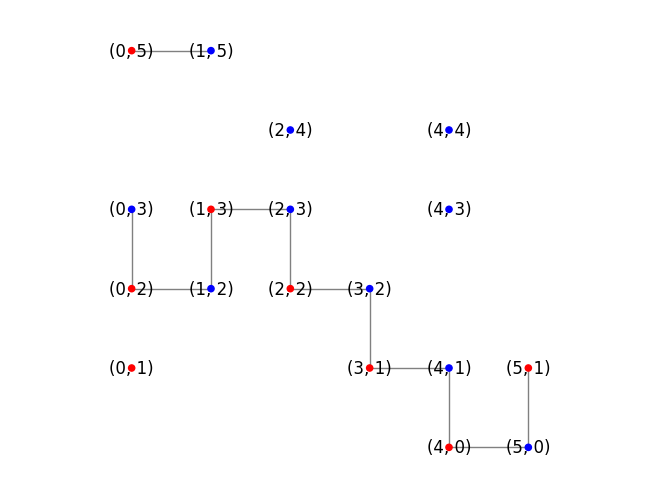

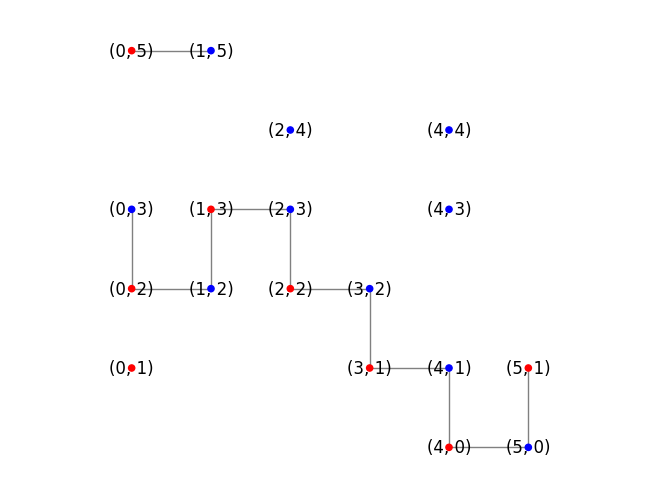

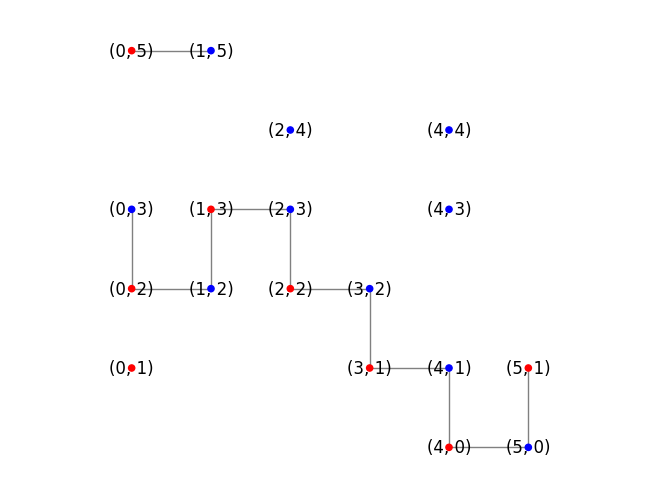

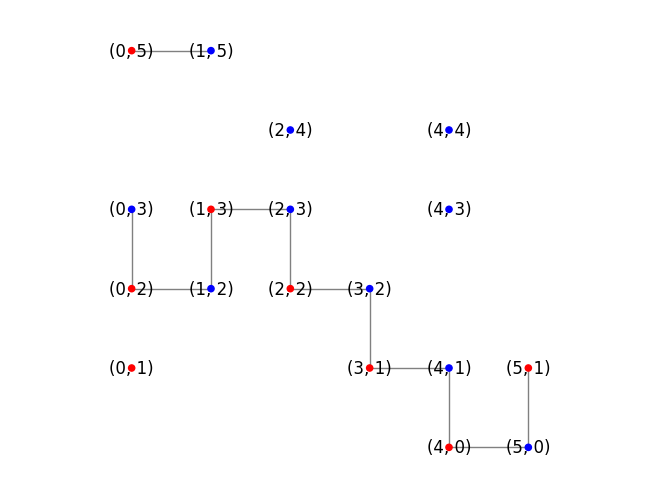

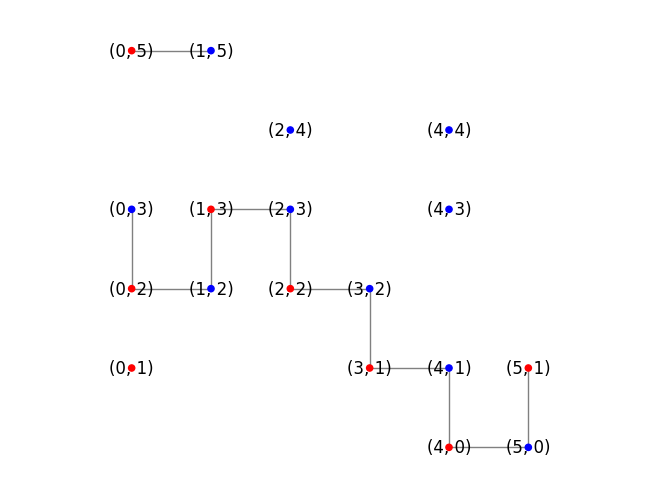

In [119]:
def get_solution_structure(solution_dict):
    solution_list = [k.split('_')[1:] for k, v in solution_dict.items() if v == 1] 
    sites = [tensor for tensor in solution_list if len(tensor) == 2]
    bonds = [tensor for tensor in solution_list if len(tensor) == 4]
    corners = [tensor for tensor in solution_list if len(tensor) == 6]
    return solution_list, sites, bonds, corners
for i in range(repeats):
    solution_list,sites, bonds, corners = get_solution_structure(all_solutions[i])
    s,b,c = get_coords(sites,bonds)
    plot_solution(s,b,c,n)

In [120]:
get_coords(sites,bonds)

([(1, 5),
  (2, 2),
  (2, 3),
  (2, 4),
  (3, 1),
  (0, 1),
  (3, 2),
  (4, 0),
  (4, 1),
  (4, 3),
  (4, 4),
  (0, 2),
  (5, 0),
  (5, 1),
  (0, 3),
  (0, 5),
  (1, 2),
  (1, 3)],
 [[(2, 2), (2, 3)],
  [(2, 2), (3, 2)],
  [(3, 1), (3, 2)],
  [(3, 1), (4, 1)],
  [(4, 0), (4, 1)],
  [(4, 0), (5, 0)],
  [(0, 2), (0, 3)],
  [(0, 2), (1, 2)],
  [(5, 0), (5, 1)],
  [(0, 5), (1, 5)],
  [(1, 2), (1, 3)],
  [(1, 3), (2, 3)]],
 ['blue',
  'red',
  'blue',
  'blue',
  'red',
  'red',
  'blue',
  'red',
  'blue',
  'blue',
  'blue',
  'red',
  'blue',
  'red',
  'blue',
  'red',
  'blue',
  'red'])

In [121]:
sites, bonds, corners

([['11', 'H'],
  ['14', 'O'],
  ['15', 'H'],
  ['16', 'H'],
  ['19', 'O'],
  ['1', 'O'],
  ['20', 'H'],
  ['24', 'O'],
  ['25', 'H'],
  ['27', 'H'],
  ['28', 'H'],
  ['2', 'O'],
  ['30', 'H'],
  ['31', 'O'],
  ['3', 'H'],
  ['5', 'O'],
  ['8', 'H'],
  ['9', 'O']],
 [['14', '15', 'O', 'H'],
  ['14', '20', 'O', 'H'],
  ['19', '20', 'O', 'H'],
  ['19', '25', 'O', 'H'],
  ['24', '25', 'O', 'H'],
  ['24', '30', 'O', 'H'],
  ['2', '3', 'O', 'H'],
  ['2', '8', 'O', 'H'],
  ['30', '31', 'H', 'O'],
  ['5', '11', 'O', 'H'],
  ['8', '9', 'H', 'O'],
  ['9', '15', 'O', 'H']],
 [['14', '20', '19', 'O', 'H', 'O'],
  ['15', '14', '20', 'H', 'O', 'H'],
  ['19', '25', '24', 'O', 'H', 'O'],
  ['20', '19', '25', 'H', 'O', 'H'],
  ['24', '30', '31', 'O', 'H', 'O'],
  ['25', '24', '30', 'H', 'O', 'H'],
  ['2', '8', '9', 'O', 'H', 'O'],
  ['3', '2', '8', 'H', 'O', 'H'],
  ['8', '9', '15', 'H', 'O', 'H'],
  ['9', '15', '14', 'O', 'H', 'O']])